Step 1: Import Necessary Libraries.



In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score

C:\Users\jeffo\AppData\Local\Temp\ipykernel_15312\235475096.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


pandas and numpy for data manipulation.
matplotlib and seaborn for data visualization.
StandardScaler for feature scaling.
KMeans for clustering.
PCA for dimensionality reduction.
RFE (Recursive Feature Elimination) and LogisticRegression for feature importance analysis.

Step 2: Load and Explore the Dataset 'listings.csv' This will help me identify the columns available, their data types, and any initial signs of missing or problematic data.

In [2]:
# Load the data
df = pd.read_csv('listings.csv')

# Display the first few rows of the dataframe
print(df.head())

# General information about the dataset
print(df.info())

       id                                               name  host_id  \
0   26057  Home in Copenhagen · ★4.91 · 4 bedrooms · 4 be...   109777   
1   26473  Townhouse in Copenhagen · ★4.55 · 6 bedrooms ·...   112210   
2   29118  Rental unit in Copenhagen · ★4.85 · 1 bedroom ...   125230   
3  318437  Rental unit in Copenhagen · ★4.86 · 1 bedroom ...  1634152   
4   31094  Condo in Copenhagen · ★4.88 · 4 bedrooms · 2 b...   129976   

  host_name  neighbourhood_group              neighbourhood   latitude  \
0      Kari                  NaN                   Indre By  55.693070   
1     Julia                  NaN                   Indre By  55.676020   
2      Nana                  NaN  Vesterbro-Kongens Enghave  55.670230   
3     Ditti                  NaN                    Nrrebro  55.692680   
4      Ebbe                  NaN  Vesterbro-Kongens Enghave  55.666602   

   longitude        room_type   price  minimum_nights  number_of_reviews  \
0  12.576490  Entire home/apt  2900.0   

Step 3: Data Cleaning and Preparation


Before i can analyze the data, i need to clean and prepare it. This includes handling missing values, encoding categorical variables, and normalizing the data.

In [3]:
# Check for missing values
print(df.isnull().sum())

# Handling missing values
# For simplicity, let's fill missing numerical values with the median and drop columns with excessive missing values or irrelevant information
df.fillna(df.median(), inplace=True)
df.drop(columns=['id', 'name', 'host_name', 'last_review', 'license', 'neighbourhood_group'], inplace=True)

# Encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Normalize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

# Check if scaling worked
if scaled_features.mean() < 0.01:  # Means are close to 0, and stds close to 1 after scaling
    print("Data is normalized.")
else:
    print("Data is not normalized properly.")

id                                    0
name                                  0
host_id                               0
host_name                             1
neighbourhood_group               18545
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                              6349
minimum_nights                        0
number_of_reviews                     0
last_review                        2401
reviews_per_month                  2401
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
license                           18545
dtype: int64


TypeError: Cannot convert [['Home in Copenhagen · ★4.91 · 4 bedrooms · 4 beds · 1.5 baths'
  'Townhouse in Copenhagen · ★4.55 · 6 bedrooms · 5 beds · 2 baths'
  'Rental unit in Copenhagen · ★4.85 · 1 bedroom · 1 bed · 1 bath' ...
  'Rental unit in Copenhagen · ★New · 1 bedroom · 2 beds · 1 bath'
  'Rental unit in Copenhagen · ★New · 3 bedrooms · 4 beds · 2 baths'
  'Rental unit in Frederiksberg · ★New · 1 bedroom · 1 bed · 1 bath']
 ['Kari' 'Julia' 'Nana' ... 'Miliana' 'Steen' 'Philip']
 ['Indre By' 'Indre By' 'Vesterbro-Kongens Enghave' ... 'Amager Vest'
  'Amager Vest' 'Frederiksberg']
 ['Entire home/apt' 'Entire home/apt' 'Entire home/apt' ...
  'Entire home/apt' 'Entire home/apt' 'Entire home/apt']
 ['2022-08-09' '2023-12-04' '2023-07-18' ... nan nan nan]] to numeric

Step 4: Visualizing the Data

Let's create some visualizations to understand how the data is structured. We'll use PCA to reduce dimensionality and plot the data.

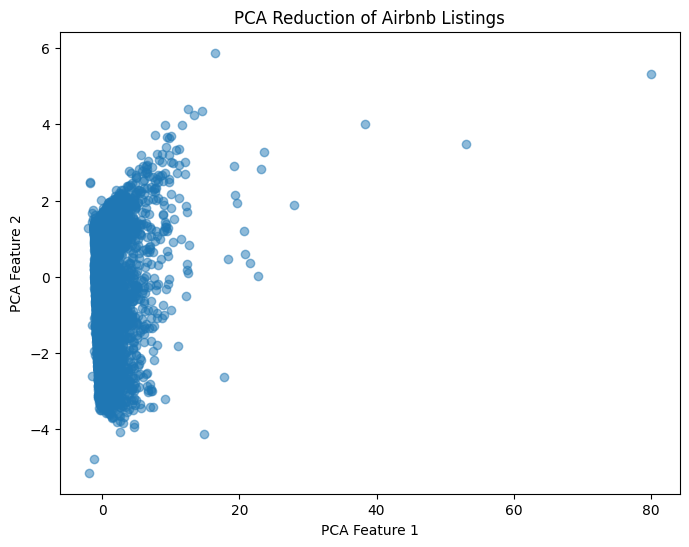

In [6]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('listings.csv')

# Drop columns with all missing values to avoid imputation issues
df.dropna(axis=1, how='all', inplace=True)

# Focus on numeric data for PCA, dropping non-numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Impute missing values in the remaining numeric columns
imputer = SimpleImputer(strategy='median')
imputed_data = imputer.fit_transform(numeric_df)
# Recreate the DataFrame with imputed data
numeric_df_filled = pd.DataFrame(imputed_data, columns=numeric_df.columns)

# Confirm no NaN values are present
assert numeric_df_filled.isnull().sum().sum() == 0, "NaN values present after imputation."

# Scale the numeric data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_df_filled)

# Apply PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Plot the PCA-reduced data
plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], alpha=0.5)
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.title('PCA Reduction of Airbnb Listings')
plt.show()

Step 5: Categorizing Accommodations

Now, i use KMeans clustering to split accommodations into categories of similarity.

C:\Users\jeffo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\jeffo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


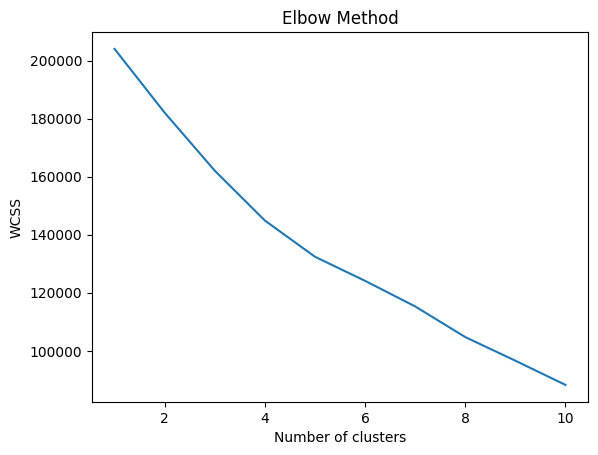

In [7]:
# Use the elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plotting the results onto a line graph to observe the 'elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within cluster sum of squares
plt.show()

After determining the optimal number of clusters, i run KMeans clustering again and analyze the results.

In [9]:
from sklearn.cluster import KMeans

# Assuming the scaled_features are already defined and scaled
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster_labels = kmeans.fit_predict(scaled_features)

# Add the cluster labels to the original DataFrame (ensure it's the DataFrame before dropping or altering columns)
df['Cluster'] = cluster_labels

# Print out the first few rows to see the cluster labels
print("First few rows with cluster labels:")
print(df.head())

# Print out the distribution of the clusters
print("\nDistribution of entries in each cluster:")
print(df['Cluster'].value_counts())

# Optionally, print out the cluster centers
print("\nCluster Centers:")
print(kmeans.cluster_centers_)

First few rows with cluster labels:
       id                                               name  host_id  \
0   26057  Home in Copenhagen · ★4.91 · 4 bedrooms · 4 be...   109777   
1   26473  Townhouse in Copenhagen · ★4.55 · 6 bedrooms ·...   112210   
2   29118  Rental unit in Copenhagen · ★4.85 · 1 bedroom ...   125230   
3  318437  Rental unit in Copenhagen · ★4.86 · 1 bedroom ...  1634152   
4   31094  Condo in Copenhagen · ★4.88 · 4 bedrooms · 2 b...   129976   

  host_name              neighbourhood   latitude  longitude        room_type  \
0      Kari                   Indre By  55.693070  12.576490  Entire home/apt   
1     Julia                   Indre By  55.676020  12.575400  Entire home/apt   
2      Nana  Vesterbro-Kongens Enghave  55.670230  12.555040  Entire home/apt   
3     Ditti                    Nrrebro  55.692680  12.554860     Private room   
4      Ebbe  Vesterbro-Kongens Enghave  55.666602  12.555283  Entire home/apt   

    price  minimum_nights  number_of_r

Step 6: Identifying Important Features

Finally, let's use a RandomForestClassifier to identify the most important features for predicting the cluster labels we've assigned.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Assuming 'df' is your DataFrame and it already includes the 'Cluster' column from previous clustering

# Splitting data into features and target
X = df.drop('Cluster', axis=1)  # Features
y = df['Cluster']  # Target variable

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# Making predictions
y_pred = rfc.predict(X_test)

# Evaluating the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


ValueError: could not convert string to float: 'Townhouse in Copenhagen · ★5.0 · 2 bedrooms · 3 beds · 1 bath'